#### Preparations

* Checkout code with `git clone -b extreme_anomaly_package ssh://git@github.com/ankit-jha/addCustomIotFn`
* cd into the directory, adapt setup.py: turn all `==` operators into `>=` to avoid accidentially uninstalling stuff
* Run `pip install .`

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GBMRegressor)
from extremeanomaly.extremeanomalygenerator import ExtremeAnomalyGenerator

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1605: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
credentials={"_id":"2d6dbddcd0ef52f54ab7e7a81f4face6",
             "tenantId":"Monitor-Demo",
             "db2":{"username":"bluadmin","password":"MjZkZTEwN2FjMWY1","databaseName":"BLUDB","port":50000,
                    "httpsUrl":"https://dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:8443",
                    "host":"dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net"},
             "iotp":{"url":"https://vrvzh6.internetofthings.ibmcloud.com/api/v0002","orgId":"vrvzh6",
                     "host":"vrvzh6.messaging.internetofthings.ibmcloud.com","port":8883,
                     "asHost":"api-beta.connectedproducts.internetofthings.ibmcloud.com",
                     "apiKey":"a-vrvzh6-am4fwylysp","apiToken":"F+PF@HQhe_N*ecS4gb"},
             "messageHub":{"brokers":["kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093"],
                           "username":"S0Zzzp1zZsF4hotd","password":"S1wyAP2jy9R2cmqcZwSfoqL5gByWSqn9"},
             "objectStorage":{"region":"global","username":"5c9b5139a83d4f68bd2fe458a2117fac",
                              "password":"5b282a68b84d070bd8674da4771998c6cb0743a4a0288129"},
             "config":{"objectStorageEndpoint":"https://s3-api.us-geo.objectstorage.softlayer.net","bos_logs_bucket":
                       "analytics-logs-monitor-demo-9c6aaaf268a1",
                       "bos_runtime_bucket":"analytics-runtime-monitor-demo-395729cb6a06",
                       "mh_topic_analytics_alerts":"analytics-alerts-Monitor-Demo"}}
db_schema=None
db = Database(credentials=credentials)
print (db)

2020-02-20T10:33:12.058 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:MjZkZTEwN2FjMWY1@dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:50000/BLUDB;


In [3]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    l2vib = []
    for index, row in df.iterrows():
        l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
        if col2 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
        if col3 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2
        l2vib.append(l2vib_element**(1/2))
    df[tcol] = np.asarray(l2vib)
    

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [4]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

/home/markus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  
/home/markus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  if __name__ == '__main__':
/home/markus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  if sys.path[0] == '':


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000


In [10]:
# now run anomaly 
EngineLogging.configure_console_logging(logging.DEBUG)
extanomii = ExtremeAnomalyGenerator(input_item='vibrations',  output_item='vibrations_anom', factor=3, size=8)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = extanomii._build_entity_type(columns = [Column('vibrations_anom',Float())], **jobsettings)
extanomii._entity_type = et

df_input = extanomii.execute(df=df_input)

2020-02-20T10:35:34.766 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-02-20T10:35:34.769 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-02-20T10:35:34.771 DEBUG iotfunctions.util.__init__ Starting trace
2020-02-20T10:35:34.773 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_ExtremeAnomalyGenerator_20200220093534
2020-02-20T10:35:34.776 DEBUG iotfunctions.util.__init__ auto_save None
2020-02-20T10:35:34.778 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-02-20T10:35:34.781 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-20T10:35:34.783 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_EXTREMEANOMALYGENERATOR
Functions:
Granularities:
No schedules metadata
2020-02-20T10:35

In [11]:
df_input2 = df_input.loc[['04714B6046D5']]
df_input2.reset_index(level=[0], inplace=True)
Temperature='vibrations'
TempAnom='vibrations_anom'

Text(0, 0.5, 'Input data - next 2 hours')

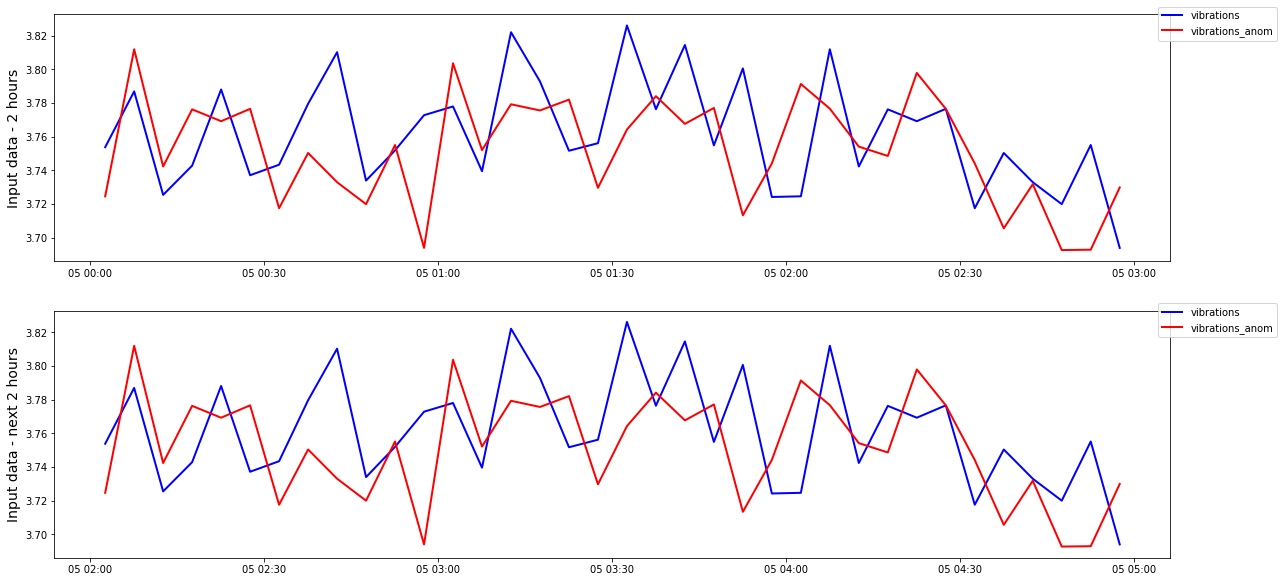

In [20]:
# Side plot - digging a bit deeper to look for seasonalities

plots = 2
df_sub1 = df_input2['2020-01-05 00':'2020-01-05 02']
df_sub2 = df_input2['2020-01-05 02':'2020-01-05 04']


fig, ax = plt.subplots(plots, 1, figsize=(20,10))
cnt = 0
ax[cnt].plot(df_sub1.index, df_sub1[Temperature],lw=2,color='blue',label=Temperature)
ax[cnt].plot(df_sub1.index, df_sub2[TempAnom],lw=2,color='red',label=TempAnom)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data - 2 hours', fontsize=14)
cnt = 1
ax[cnt].plot(df_sub2.index, df_sub1[Temperature],lw=2,color='blue',label=Temperature)
ax[cnt].plot(df_sub2.index, df_sub2[TempAnom],lw=2,color='red',label=TempAnom)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data - next 2 hours', fontsize=14)